In [13]:
!pip install chess
!pip install stockfish

In [14]:
import os
import shutil
import chess
import chess.engine
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
from stockfish import Stockfish
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
KAGGLE = True

if KAGGLE:
    input_stockfish_path = "/kaggle/input/stockfish_ubuntu/other/default/1/stockfish-ubuntu-x86-64-avx2"
    stockfish_path = "/kaggle/working/stockfish"
    if not os.path.exists(stockfish_path):
        shutil.copy(input_stockfish_path, stockfish_path)
    os.chmod(stockfish_path, 0o755)
else:
    stockfish_path = "../../models/validation_stockfish/stockfish-windows-x86-64-avx2.exe"

stockfish = Stockfish(path=stockfish_path)
stockfish.set_skill_level(20)

In [16]:
class MaskLayer(nn.Module):
    def __init__(self):
        super(MaskLayer, self).__init__()

    def forward(self, x, mask):
        return torch.mul(x, mask)

class ChessDQN(nn.Module):
    def __init__(self):
        super(ChessDQN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128*64, 128*64),  # Flattened input size for the chessboard
            nn.ReLU(),
            nn.Linear(128*64, 64*64)  # Output layer matches 64x64 move possibilities
        )

        self.mask_layer = MaskLayer()

    def forward(self, x, mask=None):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        if mask is not None:
            x = self.mask_layer(x, mask)
        return x

In [17]:
class ChessAgent:
    def __init__(self, model_path=None):
        self.epsilon = 0.9
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.gamma = 0.5 # Balance between immediate and long-term rewards
        self.learning_rate = 1e-03
        self.MEMORY_SIZE = 512 # how many steps to store for experience replay
        self.MAX_PRIORITY = 1e+06 # max priority for a sample in memory. The higher the priority, the more likely the sample will be included in training
        self.memory = []
        self.batch_size = 10

        self.policy_net = ChessDQN().to(device)
        if model_path and os.path.exists(model_path):
            state_dict = torch.load(model_path, weights_only=True)
            self.policy_net.load_state_dict(state_dict)

        self.loss_function = nn.MSELoss()
        self.optimizer = Adam(self.policy_net.parameters(), lr=self.learning_rate)

    def convert_board_to_bitarray(self, board):
        """
        Convert the chess board state to a 3D bitarray.
        """
        piece_bitboards = {
            (chess.piece_symbol(pt).upper() if color else chess.piece_symbol(pt)): board.pieces_mask(pt, color)
            for pt in chess.PIECE_TYPES for color in chess.COLORS
        }
        piece_bitboards['-'] = board.occupied ^ (2**64 - 1)
        player = (2**64 - 1) if board.turn else 0
        castling_rights = board.castling_rights
        en_passant = 0
        if board.ep_square is not None:
            en_passant = 1 << board.ep_square

        bitboards = list(piece_bitboards.values()) + [player, castling_rights, en_passant]
        # convert each bitboard into a matrix 1 and 0
        bitarray = np.array([[((bb >> i) & 1) for i in range(64)] for bb in bitboards]).reshape((16, 8, 8))

        return bitarray

    def get_move_index(self, move):
        """
        Map a chess.Move object to a unique index.
        """
        return 64 * (move.from_square) + (move.to_square)

    def mask_valid_moves(self, board):
        """
        Create a tensor mask of valid moves and a dictionary of move indices.
        """
        mask = np.zeros((64, 64))
        move_dict  = {}
        for move in board.legal_moves:
            mask[move.from_square, move.to_square] = 1
            move_dict[self.get_move_index(move)] = move
        return torch.from_numpy(mask.flatten()), move_dict

    def select_action(self, board):
        """
        Choose an action based on the current board state.
        Use an epsilon-greedy strategy.
        """
        bit_state = self.convert_board_to_bitarray(board)
        valid_moves_tensor, legal_moves = self.mask_valid_moves(board)

        if np.random.rand() < self.epsilon:
            chosen_move = random.choice(list(board.legal_moves))
        else:
            state_tensor = torch.tensor(np.array(bit_state), dtype=torch.float32).unsqueeze(0).to(device)
            q_values = self.policy_net(state_tensor)
            q_values = q_values.detach().cpu().numpy().flatten()
            valid_q_values = q_values * valid_moves_tensor.numpy()
            best_action_index = np.argmax(valid_q_values)
            chosen_move = legal_moves.get(best_action_index, random.choice(list(board.legal_moves)))

        return self.get_move_index(chosen_move), chosen_move, bit_state, valid_moves_tensor

    def remember(self, priority, state, action, reward, next_state, done, valid_moves, next_valid_moves):
        """
        Store a step in memory, ensuring it doesn't exceed maximum size.
        """
        if len(self.memory) >= self.MEMORY_SIZE:
            min_index = np.argmin([sample[0] for sample in self.memory])
            del self.memory[min_index]
        self.memory.append((priority, state, action, reward, next_state, done, valid_moves, next_valid_moves))

    def adaptive_epsilon_decay(self):
        """
        Reduce epsilon over time for less exploration.
        """
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def save_model(self, path):
        """
        Save the model weights to a file.
        """
        torch.save(self.policy_net.state_dict(), path)


    def experience_replay(self):
        """
        Perform experience replay to update the model's policy network using a prioritized replay buffer.
        """
        if len(self.memory) < self.batch_size:
            return

        priorities = np.array([sample[0] for sample in self.memory])
        probabilities = priorities / np.sum(priorities)

        minibatch_indexes = np.random.choice(len(self.memory), size=self.batch_size, replace=False, p=probabilities)
        minibatch = [self.memory[x] for x in minibatch_indexes]

        states, state_valid_moves, actions, rewards, next_states, next_state_valid_moves, dones = [], [], [], [], [], [], []

        for priority, bit_state, action, reward, next_bit_state, done, state_valid_move, next_state_valid_move in minibatch:
            states.append(bit_state)
            state_valid_moves.append(state_valid_move.unsqueeze(0))
            actions.append([action])
            rewards.append(reward)
            dones.append(done)

            if not done:
                next_states.append(next_bit_state)
                next_state_valid_moves.append(next_state_valid_move.unsqueeze(0))

        state_tensor = torch.tensor(np.array(states), dtype=torch.float32, device=device)
        action_tensor = torch.tensor(np.array(actions), dtype=torch.int64, device=device)
        reward_tensor = torch.tensor(np.array(rewards), dtype=torch.float32, device=device)
        next_state_tensor = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
        not_done_mask = torch.tensor(np.array([not done for done in dones]), dtype=torch.bool, device=device)
        state_valid_tensor = torch.cat(state_valid_moves).to(device)
        next_state_valid_tensor = torch.cat(next_state_valid_moves).to(device)

        policy_q_values = self.policy_net(state_tensor, state_valid_tensor).gather(1, action_tensor)
        with torch.no_grad():
            next_q_values = torch.zeros(self.batch_size, dtype=torch.double, device=device)
            next_q_values[not_done_mask] = self.policy_net(next_state_tensor, next_state_valid_tensor).max(1)[0]

        target_q_values = reward_tensor + self.gamma * next_q_values
        target_q_values = target_q_values.unsqueeze(1)

        loss = self.loss_function(policy_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        priority = F.mse_loss(policy_q_values, target_q_values, reduction='mean').detach().cpu().numpy()
        for idx, new_priority in zip(minibatch_indexes, priorities):
            self.memory[idx] = (new_priority, *self.memory[idx][1:])

        return float(loss)

    def generate_random_sample(self, board):
        """
        Generate a random sample for training by simulating a move.
        """
        if not board.legal_moves:
            return

        priority = 1
        state = self.convert_board_to_bitarray(board)
        valid_moves, _ = self.mask_valid_moves(board)

        random_move = random.choice(list(board.legal_moves))
        action = self.get_move_index(random_move)
        board.push(random_move)

        if board.is_game_over() or not list(board.legal_moves):
            reward = 10.0 if board.is_checkmate() else 3.0  # Final reward logic
            done = True
            next_state = self.convert_board_to_bitarray(board)
            next_valid_moves = torch.zeros_like(valid_moves)  # No valid moves
        else:
            random_move_black = random.choice(list(board.legal_moves))
            board.push(random_move_black)
            next_state = self.convert_board_to_bitarray(board)
            done = board.is_game_over()
            next_valid_moves, _ = self.mask_valid_moves(board)
            board.pop()

            if board.is_checkmate():
                reward = -10.0  # Loss for the agent
            elif board.is_stalemate() or board.is_insufficient_material():
                reward = 3.0  # Draw
            else:
                reward = 0.2  # Intermediate move

        board.pop()
        self.remember(priority, state, action, reward, next_state, done, valid_moves, next_valid_moves)

    def game_result(self, board):
        """
        Determine the game result.
        """
        if board.is_checkmate():
            return 1 # Win
        elif board.is_stalemate() or board.is_insufficient_material():
            return 0 # Draw
        else:
            return -1 # Loss

    def play_single_game(self, board, max_moves):
        """
        Simulate a single game for training.
        """
        done, game_moves, game_loss = False, 0, []

        while not done and game_moves < max_moves:
            action_index, chosen_move, bit_state, valid_moves_tensor = self.select_action(board)
            board.push(chosen_move)
            self.generate_random_sample(board)
            loss_value = self.experience_replay()
            if loss_value is not None:
                game_loss.append(loss_value)
            done = board.is_game_over()
            game_moves += 1

        return sum(game_loss) / len(game_loss) if game_loss else 0.0, self.game_result(board)

    def q_learning(self, games_to_play, max_game_moves, board_config=None):
        """
        Train the agent using Q-learning.
        """
        loss, final_score, steps = [], [], 0

        for _ in tqdm(range(games_to_play), desc="Training Games"):
            board = chess.Board() if board_config is None else chess.Board(board_config)
            game_loss, result = self.play_single_game(board, max_game_moves)
            loss.append(game_loss)
            final_score.append(result)
            self.adaptive_epsilon_decay()

        return pd.DataFrame({"Loss": loss, "Score": final_score})

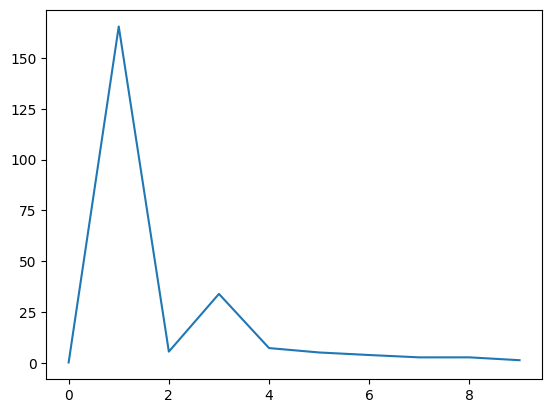

In [18]:
board = chess.Board()
agent = ChessAgent()

for i in range(10):
    agent.generate_random_sample(board)

loss = []
for i in range(10):
    loss.append(agent.experience_replay())

plt.plot(loss)
plt.show()

In [19]:
df = agent.q_learning(games_to_play=1000, max_game_moves=50)

Training Games: 100%|██████████| 1000/1000 [36:25<00:00,  2.19s/it]


In [20]:
non_zero_rows = df[df['Score'] != -1]
non_zero_rows

,Loss,Score
7,0.020946,1
28,0.011023,1
53,0.007552,1
139,0.003787,1
145,0.002382,1
319,0.009095,1
496,0.000868,1
501,0.002806,1
678,0.000696,1
685,0.001676,1


In [25]:
test_agent = agent

In [26]:
def configure_stockfish_using_skill_level(skill_level):
    stockfish = Stockfish(path=stockfish_path)
    stockfish.set_skill_level(skill_level)
    return stockfish

def configure_stockfish_using_rating(elo_rating):
    stockfish = Stockfish(path=stockfish_path)
    stockfish.set_elo_rating(elo_rating)
    return stockfish

def play_single_stockfish_game(agent, stockfish, max_moves=50):
    board = chess.Board()
    stockfish.set_fen_position(board.fen())

    for move_count in range(max_moves):
        if board.turn:
            _, move, _, _ = agent.select_action(board)
        else:
            move = chess.Move.from_uci(stockfish.get_best_move())
        board.push(move)
        stockfish.set_fen_position(board.fen())

        if board.is_game_over():
            break

    return board.result()

def evaluate_agent(agent, skill_levels, games_per_rating=20):
    results = []

    for level in skill_levels:
        stockfish = configure_stockfish_using_skill_level(level)
        outcomes = {"Wins": 0, "Losses": 0, "Draws": 0}

        for _ in range(games_per_rating):
            result = play_single_stockfish_game(agent, stockfish)
            if result == "1-0":
                outcomes["Wins"] += 1
            elif result == "0-1":
                outcomes["Losses"] += 1
            else:
                outcomes["Draws"] += 1

        win_rate = (outcomes["Wins"] + 0.5 * outcomes["Draws"]) / games_per_rating
        outcomes["Win Rate"] = win_rate
        outcomes["Stockfish Level"] = level
        results.append(outcomes)

        print(f"Stockfish level: {level}: {outcomes}")

    return results

stockfish_skill_levels = [1, 5, 10, 15]
results = evaluate_agent(test_agent, stockfish_skill_levels)

Stockfish level: 1: {'Wins': 0, 'Losses': 13, 'Draws': 7, 'Win Rate': 0.175, 'Stockfish Level': 1}
Stockfish level: 5: {'Wins': 0, 'Losses': 12, 'Draws': 8, 'Win Rate': 0.2, 'Stockfish Level': 5}
Stockfish level: 10: {'Wins': 0, 'Losses': 15, 'Draws': 5, 'Win Rate': 0.125, 'Stockfish Level': 10}
Stockfish level: 15: {'Wins': 0, 'Losses': 18, 'Draws': 2, 'Win Rate': 0.05, 'Stockfish Level': 15}
